In [287]:
import data_loader
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm import tqdm
import numpy as np
congress = "senate"

In [288]:
isHouse = congress == "house"
arr, reps, bills = data_loader.house_records() if isHouse else data_loader.senate_records()

In [289]:
print(bills[0])
print(arr.shape)

{'question': 'On the Motion to Proceed', 'vote_title': 'Motion to Proceed to Consider H.Con.Res. 112', 'vote_result': 'Motion to Proceed Rejected', 'congress_year': '2012', 'vote_result_text': 'Motion to Proceed Rejected (41-58)', 'majority_requirement': '1/2', 'vote_number': '98', 'session': '2', 'vote_date': 'May 16, 2012,  04:22 PM', 'congress': '112', 'vote_document_text': 'A concurrent resolution establishing the budget for the United States Government for fiscal year 2013 and setting forth appropriate budgetary levels for fiscal years 2014 through 2022.', 'vote_question_text': 'On the Motion to Proceed H.Con.Res. 112'}
(190, 3623)


In [290]:
def getBillKey(bill):
    if isHouse: return 10000*int(bill["congress"]) + 1000*int(bill["session"][0]) + int(bill["rollcall-num"])
    else: return 10000*int(bill["congress"]) + 1000*int(bill["session"]) + int(bill["vote_number"])
print(max([int(bill["congress"]) for bill in bills]))
print(max([int(bill["session"][0]) for bill in bills]))
if(isHouse): print(max([int(bill["rollcall-num"]) for bill in bills]))
else: print(max([int(bill["vote_number"]) for bill in bills]))

116
2
442


In [291]:
billkeys = [getBillKey(bill) for bill in bills]
indices = [i for i, _ in sorted(enumerate(billkeys), key=lambda x:x[1])]
bills = [bills[i] for i in indices]
arr = arr[:, indices]

Markey (D-MA)


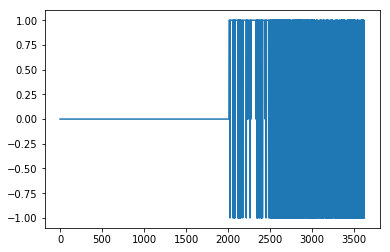

In [292]:
def infoRep(repid):
    print(reps[repid])
    plt.plot(arr[repid])
    plt.show()
    
infoRep(120)

In [293]:
# first bill of each session
firstbills = []
for bill in bills:
    if((isHouse and bill["rollcall-num"] == "1") or ((not isHouse) and bill["vote_number"] == "1")):
        firstbills.append(bill)
if isHouse: print([bill["action-date"] for bill in firstbills])
else: print([bill["vote_date"] for bill in firstbills])

['January 8, 2007,  12:01 PM', 'January 22, 2008,  05:32 PM', 'January 11, 2009,  02:00 PM', 'January 20, 2010,  12:01 PM', 'January 26, 2011,  02:26 PM', 'January 23, 2012,  05:32 PM', 'January 24, 2013,  07:54 PM', 'January 6, 2014,  05:30 PM', 'January 8, 2015,  01:46 PM', 'January 11, 2016,  05:32 PM', 'January 4, 2017,  12:38 PM', 'January 3, 2018,  05:28 PM', 'January 8, 2019,  05:39 PM']


In [294]:
def filterReps(bill, inactiveThresh=None):
    """Find indices of representatives who have been around since bill.
    
    inactiveThresh specifies how many no-votes in a row indicate an inactive representative; default
    value is 20 or 50"""
    if not inactiveThresh: inactiveThresh = 50 if isHouse else 20
    billkey = getBillKey(bill)
    goodreps = []
    for i in range(len(reps)):
        streak = 0
        isgood = True
        for j in range(len(bills)):
            if(getBillKey(bills[j]) >= billkey): # if more recent than billkey
                if(arr[i][j] == 0): streak += 1
                else: streak = 0
                if(streak == inactiveThresh): isgood = False
        if(isgood): goodreps.append(i)
    return goodreps

def filterByParty(repindices, party):
    filteredreps = []
    for index in repindices:
        if reps[index][-5] == party:
            filteredreps.append(index)
    return filteredreps

def billsSince(bill):
    """Count how many bills have transpired since input bill."""
    count = 0
    for b in bills:
        if getBillKey(b) >= getBillKey(bill):
            count += 1
    return count

In [295]:
print(filterByParty(filterReps(firstbills[-2]), "D")) # test

[4, 9, 14, 17, 21, 28, 30, 31, 32, 43, 46, 61, 66, 71, 79, 80, 83, 86, 96, 97, 105, 112, 119, 120, 126, 127, 131, 132, 138, 141, 153, 154, 158, 161, 166, 171, 177, 178, 182, 184, 186, 188]


In [296]:
# how far back can we go while still having N active senators from then to today?
Ns = []
found = False
for i in range(len(firstbills)):
    Ns.append(len(filterReps(firstbills[i])))
Bs = [billsSince(bill) for bill in firstbills]

[[27, 3623], [29, 3181], [36, 2966], [36, 2569], [47, 2270], [47, 2035], [57, 1784], [59, 1493], [74, 1127], [76, 788], [84, 625], [89, 300], [100, 26]]


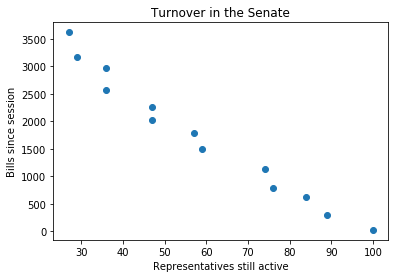

In [297]:
print([[Ns[i], Bs[i]] for i in range(len(Ns))])
plt.scatter(Ns, Bs)
plt.xlabel("Representatives still active")
plt.ylabel("Bills since session")
congresstitle = "House" if isHouse else "Senate"
plt.title("Turnover in the "+congresstitle)
plt.show()

In [298]:
# inspect above graph and set index
index = 8
print([[Ns[i], Bs[i]] for i in range(len(Ns))][index])
print(firstbills[index])

[74, 1127]
{'vote_result': 'Amendment Rejected', 'congress': '114', 'question': 'On the Amendment', 'vote_date': 'January 8, 2015,  01:46 PM', 'vote_question_text': 'On the Amendment S.Amdt. 1 to H.R. 26 (Terrorism Risk Insurance Program Reauthorization Act of 2015)', 'vote_document_text': 'In the nature of a substitute.', 'session': '1', 'vote_result_text': 'Amendment Rejected (31-66, 3/5 majority required)', 'vote_title': 'Warren Amdt. No. 1', 'majority_requirement': '3/5', 'vote_number': '1', 'congress_year': '2015'}


In [299]:
if not isHouse: # senate
    choice = 8
    arrD = arr[filterByParty(filterReps(firstbills[choice]), "D"), :]
    arrD = arrD[:, -billsSince(firstbills[choice]):]
    arrR = arr[filterByParty(filterReps(firstbills[choice]), "R"), :]
    arrR = arrR[:, -billsSince(firstbills[choice]):]
    np.save("senate_votes_d", arrD)
    np.save("senate_votes_r", arrR)
if isHouse:
    choice = 6
    arrD = arr[filterByParty(filterReps(firstbills[choice]), "D"), :]
    arrD = arrD[:, -billsSince(firstbills[choice]):]
    arrR = arr[filterByParty(filterReps(firstbills[choice]), "R"), :]
    arrR = arrR[:, -billsSince(firstbills[choice]):]
    np.save("house_votes_d", arrD)
    np.save("house_votes_r", arrR)